# Cross/auto-correlation, periodograms and unevenly sampled data
This is a brief introduction to some basic techniques of *Time-Series Analysis*, that are directrly applied to astronomical time-series, and sometimes form the basis of more advanced methods:
- *cross-correlation* of signals
- *auto-correlation* of a signal
- *power spectral density* and *periodogram*
- the *Lomb-Scargle* periodogram

In addition, we will demonstrate the usage of the `scipy` implementations, applied on simulated signals. Please, run the following block to import the necessary packages.

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.signal import correlate, periodogram, lombscargle, sawtooth

mpl.rcParams['figure.figsize'] = (10,5)    # bigger plots

# Chapter 1: Correlation techniques

## Cross-correlation
A **measure** of similarity of the two signals when a displacement (*lag*) if applied to one of them, is the **cross-correlation** [3]. Let $x(t)$ and $y(t)$ two integrable signals. The cross-correlation with lag $\tau$ of the two signals is:
$$
R_{xy}(\tau) = (x \star y)(\tau) \stackrel{\text{def}}{=}
\int\limits_{-\infty}^{\infty} x^{*}(t) y(t + \tau) dt \equiv
\int\limits_{-\infty}^{\infty} x^{*}(t - \tau) y(t) dt $$

Be careful with the similarity to **convolution**:
$$ (x \ast y)(\tau) \stackrel{\text{def}}{=} \int\limits_{-\infty}^{\infty} x(t) y(\tau - t) dt $$
### When do we use it?
The cross-correlation technique is used to find a signal, e.g. *a template*, in another signal (see *Matched Filter*, *Signal Matching*, *Pattern Recognition*). The position of the searched signal is the *lag* which if used in the above formula, gives maximum power.
### Relation to FT
The *Correlation theorem* states that
$$ \mathcal{F} \left\{ (x \star y)(\tau)\right\} = X^{*}(f) Y(f) $$
where
$$ X(f) = \mathcal{F}\left\{ x(t) \right\} $$
$$ Y(f) = \mathcal{F}\left\{ y(t) \right\} $$
## Example: a cross-correlogram for signal matching
In the lightcurve of a star, it is possible to observe flares. Let's say we have a model that produces sawtooth-like signals. We construct a "flare" with our model and we cross-correlate it with a given lightcurve.

Below, we simulate the signal as two successive flares of different amplitude. We also add background and Poisson noise. Additionally, the second flare is altered (exponent $0.333$) to make it less steep: astrophysical processes are much more complicated than our models!

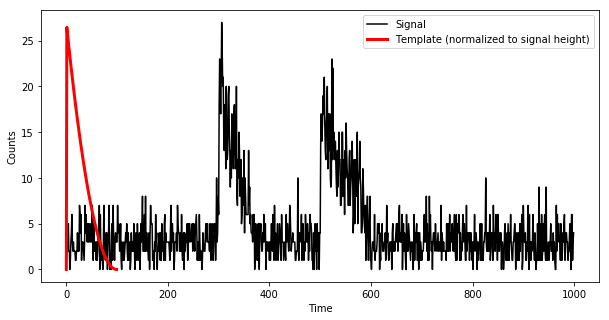

In [14]:
# Template creation
t = np.linspace(0, 1, 100)                         # phase in [0, 1] for the template
A = ((sawtooth(-2 * np.pi * t) + 1) / 2) ** 2.0    # the sawtooth template

# Signal parameters
amplitude1 = 20                                    # amplitude of first flare
amplitude2 = 13                                    # amplitude of second flare
background = 3                                     # background level
shot_noise = True                                  # wether to add Poisson noise or not

# Simulate a signal
B = np.zeros(1000)                                 # start from baseline 0
B[300:400] = amplitude1 * A                        # add first flare
B[500:600] = amplitude2 * A ** 0.333               # add second flare ('distorted')
B += background                                    # add background
if shot_noise:
    B = np.random.poisson(B)                       # add Poisson noise

plt.plot(B, "k-", label="Signal")
plt.plot(A * np.max(B), "r-", lw=3, label="Template (normalized to signal height)")
plt.xlabel("Time")
plt.ylabel("Counts")
plt.legend()
plt.show()

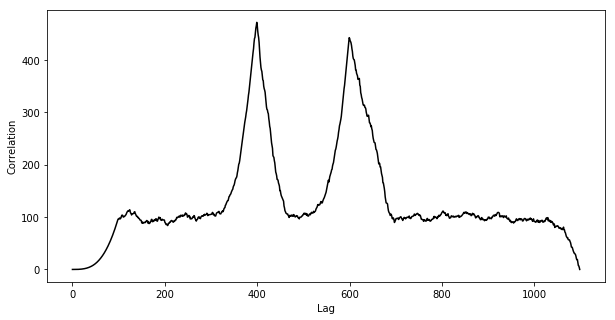

In [15]:
C = correlate(B, A)      # cross-correlate the signal with the template
plt.plot(C, "k-")            # shift by the length of the template
plt.xlabel("Lag")
plt.ylabel("Correlation")
plt.show()

## Auto-correlation
If we cross-correlate the signal with itself, $x(t) = y(t)$, then we have an *auto-correlation*:
$$ (x \star x)(\tau) = \int\limits_{-\infty}^{\infty} x^{*}(t - \tau) x(t) dt \leftrightarrow \left| X(f) \right|^2 $$
> The Fourier transform of the auto-correlation is the power spectrum! This is the **Wiener-Khinchin Theorem**

### When do we use it?
Why would it be useful to correlate a signal with itself? When we apply a *lag* $\tau$ to a signal and cross-correlated it with itself, then if there is a **repeating pattern** with period $\tau$, then the power will be higher than in the cases of irrelevant time lags.
>Note: the maximum power is always yielded for $\tau=0$ as it corresponds to the total power of the signal

### Power Spectral Density
The *two-sided Power Spectral Density (PSD)* of $x(t)$ is:
$$ PSD_x(f) = \frac{1}{2} \left( \left|X(f)\right|^2 + \left|X(-f)\right|^2 \right) $$
For a ***real*** signal, $x(t) \in \mathcal{R}$:
$$ X(f) = X^{*}(-f)
    \quad \Rightarrow \quad \left|X(f)\right| = \left|X(-f)\right|
    \quad \Rightarrow \quad PSD_x(f) = \left|X(f)\right|^2
$$
## Example: an auto-correlogram for periodicity searching
The cross-correlogram of the signal with itself is called auto-correlogram. Let's apply it for the previous example's signal.

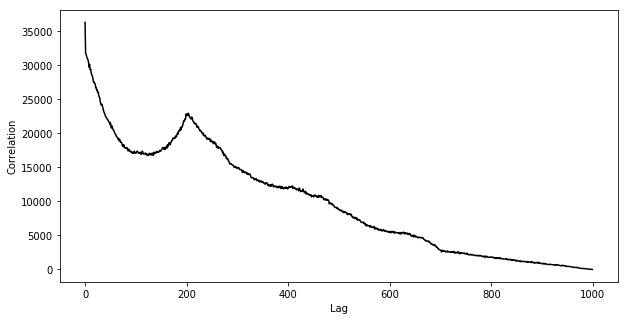

In [18]:
D = correlate(B, B)   # auto-corrleation
D = D[D.size // 2:]   # take half the output (it's like DFT symmetry)
plt.plot(D, "k-")
plt.xlabel("Lag")
plt.ylabel("Correlation")
plt.show()

# Chapter 2: periodicity search

## The case of evenly sampled signals
Let's create an evenly sampled sinusoidal signal with values $\in \left[0, 2A\right]$. The observation times are multiples of a sampling interval and the sampling frequency is the inverse of the latter. Also, we will add background and Poisson noise.

For better illustration, we define the `zoom_region` variable that holds the minimum and maximum frequency plotted when we want to zoom the periodograms.

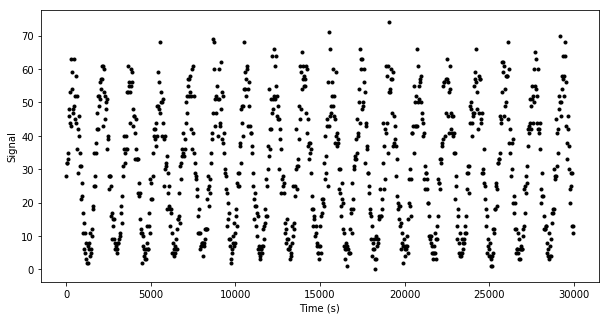

In [30]:
# SIGNAL PROPERTIES
n_observations = 1000            # number of observations in the timeseries
sampl_interval = 30.0            # sampling interval (in seconds)
signal_amplitude = 25            # amplitude (in counts)
signal_period = 1700.0           # period (in seconds)
background = 5                   # add some background (in counts)
shot_noise = True                # whether to add Poisson noise or not

# FOR PLOTS
signal_freq = 1 / signal_period
zoom_region = [0.001 * signal_freq, 2.0 * signal_freq]  # region to zoom in, around true frequency

# CREATE AND PLOT THE SIGNAL
t = np.arange(n_observations) * sampl_interval                           # observation times [0, t, 2t, ...]
x = background + signal_amplitude * (1 + np.sin(2 * np.pi / signal_period * t))              # create the signal
if shot_noise:
    x = np.random.poisson(x)

plt.plot(t, x, "k.")
plt.xlabel("Time (s)")
plt.ylabel("Signal")
plt.show()

## Periodogram: discrete Power Spectral Density estimation
If $x_i$ are the $N$ samples taken with sampling interval $\tau$, then the *periodogram estimate of the power spectrum* is the discrete form the the power spectral density formula we defined above:
$$P(f_k) = \frac{1}{N^2} \left(\left|C_k\right|^2 + \left|C_{N-k}\right|^2\right)$$
defined for non-negative frequencies
$$f_k \equiv \frac{k}{N\tau}$$
where
$$C_k=\sum\limits_{j=0}^{N-1}{ x_j e^{2\pi i \frac{j}{N} k }}$$

### Implementation in `scipy`
In the package `scipy`, we find the sub-package called `signal` which hosts implementations of many algorithms commonly used in *Signal Processing*. The function `scipy.signal.periodogram` implements the classic periodogram, returning both the list of frequencies and the power spectral density computed for them:
> `<list of frequencies>, <power spectral density> = periodogram(<signal>, <sampling frequency>)`

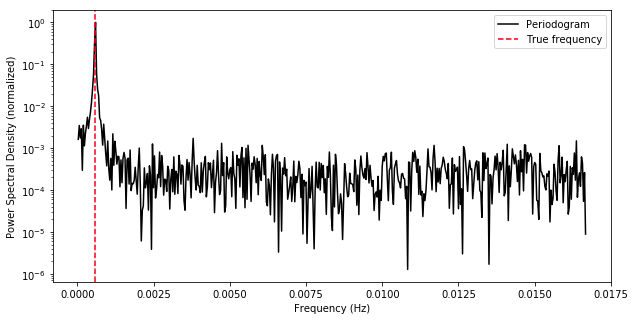

In [31]:
plot_in_log = True
zoom = False

freqs, PSD = periodogram(x, 1.0 / sampl_interval)
PSD /= np.max(PSD)

plt.plot(freqs[1:], PSD[1:], "k-", label="Periodogram")
plt.axvline(signal_freq, color="r", ls="--", label="True frequency")

plt.xlabel("Frequency (Hz)")
plt.ylabel("Power Spectral Density (normalized)")
if plot_in_log:
    plt.yscale("log")
if zoom:
    plt.xlim(zoom_region)
plt.legend()
plt.show()

## Unevenly Sampled Data
Examples of *missing data* from Observational Astrophysics:
- With **ground telescopes** we cannot observe objects continuously for more than a few hours. Observations spanning many days or months are dominated by gaps. Even in **space telescopes** there are organizational or maintenance operations requiring observation to hold.
- In the case of **space telescopes**, corrections in pointing, turbulence from movement of mechanical parts etc., can stop observations for very short times. For example, in *Kepler* mission, with sampling rate of $\sim 30$ minutes, every weeks or so there are gaps of $1-8$ hours.
- Even if we observe for a short time and the regular sampling interval is achievable, a **random event** (e.g. malfunction, human error) can create a delay, cutting our observation into **two** evenly spaced timeseries.
- **More data** is usually **better data**. Imagine the case of multiple observations, overlapping or not, with their own sampling rates, with or without missing/bad data, etc. If we succeed in calibrating them, reject bad data, then the combination will be a timeseries with *ugly* structure but with valuable temporal information.

### Simulation of unevenly sampled signal

Let's take the previous signal and 
- remove randomly some observations - like removing bad data - by setting `fraction_random`
- remove a region around the middle - simulating a gap in observation - by setting `fraction_at_center`
- halve the sampling rate after the middle region - e.g. longer exposures - by setting `halve_sample_rate = True`

Try various scenarios:
- toggle on and off the three `missing data` scenarios by setting percentages to $0$ or `False` for `halve_sample_rate`
- increase the background level or decrease the amplitude in the code creating the signal (two blocks above) to see pure Poisson noise

Kept 41.8% of the initial data points


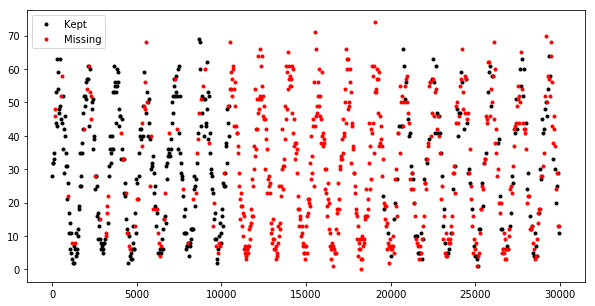

In [41]:
fraction_at_center = 0.3
halve_sample_rate = True
fraction_random = 0.2

region_left = int(n_observations * (0.5 - fraction_at_center / 2))
region_right = int(n_observations * (0.5 + fraction_at_center / 2))
random_indices = np.random.choice(n_observations, size=int(n_observations * fraction_random), replace=False)
keep = np.ones_like(x, dtype=bool)
keep[random_indices] = False
keep[region_left:region_right] = False
if halve_sample_rate:
    keep[region_right::2] = False

print("Kept {:.4}% of the initial data points".format((100.0 * np.sum(keep)) / n_observations))

t2 = t[keep]
x2 = x[keep]
plt.plot(t2, x2, "k.", label="Kept")
plt.plot(t[~keep], x[~keep], "r.", label="Missing")
plt.legend()
plt.show()

## Naïve application of periodogram or DFT
What if we ignore the missing data by assuming the sampling interval is $\frac{T}{N}$ where $T$ is the total duration of the signal and $N$ is the number of data points?

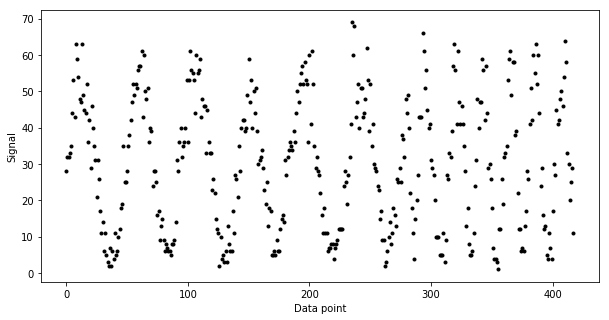

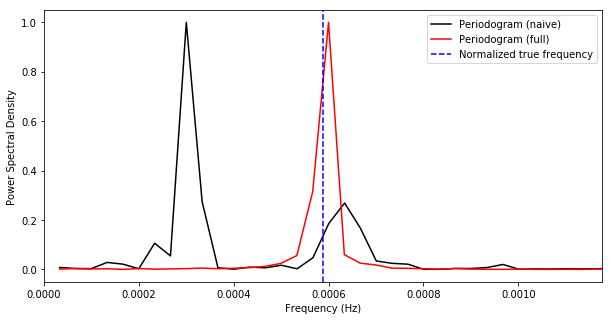

In [42]:
zoom = True
plot_in_log = False

plt.plot(x2, "k.")
plt.xlabel("Data point")
plt.ylabel("Signal")
plt.show()

new_interval = max(t2) / len(t2)
freqs_ignore, PSD_ignore = periodogram(x2, 1 / new_interval)
PSD_ignore /= np.max(PSD_ignore)

plt.plot(freqs_ignore[1:], PSD_ignore[1:], color="k", label="Periodogram (naive)")
plt.plot(freqs[1:], PSD[1:], color="r", label="Periodogram (full)")
plt.axvline(signal_freq, color="b", ls="--", label="Normalized true frequency")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power Spectral Density")
plt.legend()
if plot_in_log: plt.yscale("log")
if zoom: plt.xlim(zoom_region)
plt.show()

### Setting missing values as $0$
In order to keep the temporal information, let's set the missing data equal to $0$!

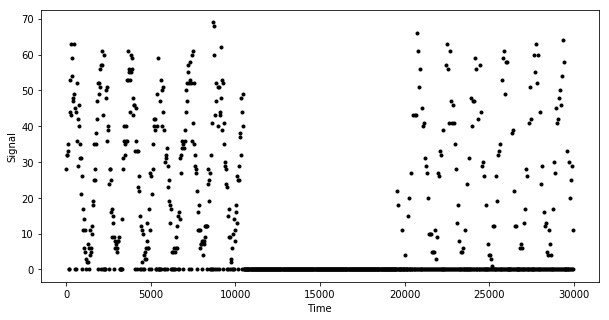

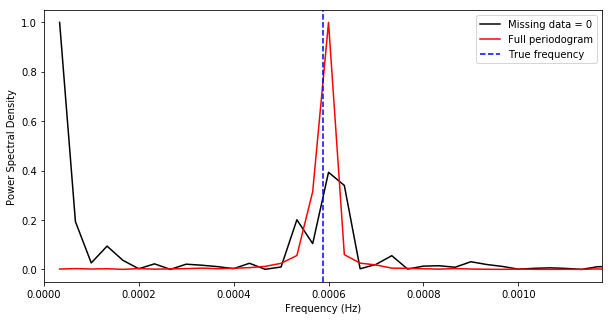

In [43]:
zoom = True
plot_in_log = False

t3 = t.copy()
x3 = x.copy()
x3[~keep] = 0
plt.plot(t3, x3, "k.")
plt.xlabel("Time")
plt.ylabel("Signal")
plt.show()

freqs_zeros, PSD_zeros = periodogram(x3, 1 / sampl_interval)
PSD_zeros /= np.max(PSD_zeros)
plt.plot(freqs_zeros[1:], PSD_zeros[1:], color="k", label="Missing data = 0")
plt.plot(freqs[1:], PSD[1:] / max(PSD[1:]), color="r", label="Full periodogram")
plt.axvline(signal_freq, color="b", ls="--", label="True frequency")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power Spectral Density")
if plot_in_log:
    plt.yscale("log")
plt.legend()
if zoom: plt.xlim(zoom_region)
plt.show()

## The Lomb-Scargle Periodogram
For unevenly sampled data, there is a special type of periodogram that is defined for arbitrary frequencies, called **Lomb-Scargle periodogram**. For $N$ data points $x_i$ at times $t_i$, the spectral power as a function of the angular frequency $\omega \equiv 2\pi f$ is:

$$ P_N(\omega) = \frac{1}{2\sigma^2} \left\{
    \frac{ \left[ \sum_j \left(x_j - \bar{x}\right)\cos{\omega\left(t_j - \tau\right)}\right]^2 }
         { \sum_j \cos^2{\omega\left(t_j - \tau\right)} }
  + \frac{ \left[ \sum_j \left(x_j - \bar{x}\right)\sin{\omega\left(t_j - \tau\right)}\right]^2 }
         { \sum_j \sin^2{\omega\left(t_j - \tau\right)} }
\right\} $$

(equation 13.8.3 in [1])

### Implementation in `scipy`
As with the `periodogram`, there is an implementation of the *LS* algorithm in the same sub-package, `scipy.signal.lombscarge`. It does not return frequencies, as in that case we define them explicitly.

>Be careful though: here the frequencies are ***angular***: $\omega_i = 2\pi f_i$

The syntax is the following:
> `<power spectral density> = lombscargle(<times>, <signal>, <requested angular frequencies>`

Additionally, we can add the argument `normalize=True` for automatic normalization of the periodogram to the total power of the signal.

### Historical note
All common generalizations of the standard periodogram for unevenly sampled data are based on fitting sinusoids with the method of least squares. The first **Least Square Spectral Analysis** method was the **Vaníček method** after Petr Vaníček [2].
Subsequent contributions from Nicholas Lomb and Jeffrey Scargle during the 70s and 80s resulted into the traditional tools we still use today.

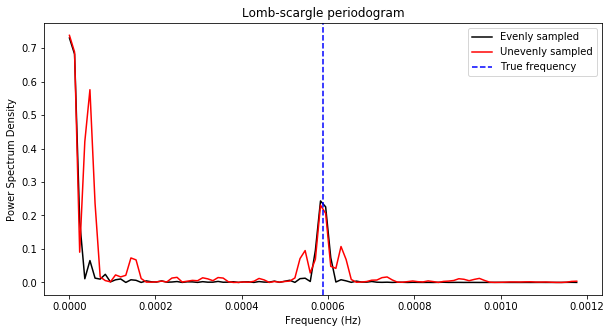

In [44]:
from scipy.signal import lombscargle


zoom = True             # if False, we will zoom around the true frequency
plot_in_log = False     # if True, we will plot in log-scale

# do not change these...
frequencies = freqs[1:] if not zoom else np.linspace(zoom_region[0], zoom_region[1], 100)
angular_frequencies = 2 * np.pi * frequencies

# create the periodograms
periodogram_even = lombscargle(t, x, angular_frequencies, normalize=True)
periodogram_uneven = lombscargle(t2, x2, angular_frequencies, normalize=True)

# plot the result
plt.title("Lomb-scargle periodogram")
plt.plot(frequencies, periodogram_even, "k-", label="Evenly sampled")
plt.plot(frequencies, periodogram_uneven, "r-", label="Unevenly sampled")
plt.axvline(signal_freq, color="b", ls="--", label="True frequency")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power Spectrum Density")
if plot_in_log:
    plt.yscale("log")
plt.legend()
plt.show()

## Further reading
### Confidence intervals
Detecting periodicity in a signal is a problem that we translate to a **peak detection problem** with periodograms (or simple DFT). Note that **even pure noise will display some peaks** (false alarms). Additional complications can be created by **spectral leakage** due to the discrete nature of measured signals.

Consequently, it is crucial to compute confidence intervals of the peak values for all frequencies in our periodogram. A method for doing so is described in [4].

### For Bayesianists...
The previous methods and their theoretical investigation rely on the application of classic tools (e.g. Fourier Transform, Least Squares Fitting.) In 1992, a very important paper [5] presents a Bayesian framework for detecting periodic signals of **unknown shape or period**, displaying the attractiveness of *all things Bayesian...*:
- use of priors
- model comparison
- quantification of Ockham's razor
- parameter estimation (even in lightcurve shape!)

They also modify their method to create a **non-periodic source variability test**.

## References

[1] Press, W. H., Teukolsky, A. S., Vetterling, W. T. and Flannery, B. P. (2007). "Numerical Recipes: The Art of Scientific Programming" (3rd Edition). Cambridge University Press.

[2] Vaníček, P. (1969). "Approximate spectral analysis by least-squares fit". Astrophysics and Space Science, 4(4): 387-391. 

[3] Riley, K. F., Hobson, M. P. and Bence, S. J. (2006). "Mathematical Methods for Physics and Engineering" (3rd Edition). Cambridge University Press.

[4] Horne, J. H and Baliunas, S. L. (1986). "A prescription for period analysis of unevenly sampled time series". The Astrophysical Journal, 302: 757-763.

[5] Gregory, P. C. and Loredo T. J. (1992). "A new method for the detection of a periodic signal of unknown shape and period". The Astrophysical Journal, 398: 146-168.
